# Predictive Modelling

In [312]:
%store -r  df_model features_x features_y

In [313]:
# Data handling

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance


from sklearn.ensemble import RandomForestRegressor
#from fbprophet import Prophet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from neuralprophet import NeuralProphet
from fbprophet.plot import plot_components_plotly




In [314]:
df_model.sales = df_model.sales.apply(lambda x: np.nan if x == 0 else x)
df_model.loc[df_model['is_train'] == 1, 'saleslog'] = np.log(1+df_model.loc[df_model['is_train'] == 1]['sales'])

In [315]:
# Train Test Split

data = df_model.loc[(df_model['is_train'] == 1)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x], 
                                                    data[features_y], 
                                                    test_size=0.2, 
                                                    random_state=3)

In [316]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(675470, 21) (675470, 1) (168868, 21) (168868, 1)


## XGBoost

In [6]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

num_round = 1000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6, 
         'objective': 'reg:squarederror',}

plst = list(param.items())

In [7]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [20]:
model_xgb = xgb.train(plst, dtrain, num_round, evallist,
                  feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=100)

[0]	train-rmse:8.18570	train-rmspe:0.99986	test-rmse:8.18796	test-rmspe:0.99986


KeyboardInterrupt: 

In [8]:
#make a submission dataframe to test RMSPE for unseen test-data (test.csv)
submit = df_model.loc[df_model['is_train'] == 0]
dsubmit = xgb.DMatrix(submit[features_x])
predictions = model_xgb.predict(dsubmit)

df_predictions = submit['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_xgboost_03.csv', index=False)

NameError: name 'model_xgb' is not defined

In [ ]:
#Print Feature Importance
plt.figure(figsize=(18,8))

plot_importance(model)
plt.show()
plt.savefig('xgboost_03_feature_importance.png')

In [ ]:
# save dataframes on disk
df.to_csv('dataframe_raw', index=False)
df_model.to_csv('dataframe_raw_model3', index=False)
data.to_csv('dataframe_modeldata3', index=False)

In [ ]:
# save model using pickle
import pickle
filename = 'model_xgboost_03.sav'
pickle.dump(model, open(filename, 'wb'))


In [ ]:
# load pickled model
import pickle
#loaded_model = pickle.load(open("/Users/bur.oez/Desktop/Capstone-Project-Rossman-Sales Kopie/model_xgboost_01.sav", 'rb'))

## Artificial Neural Networks

To assess the performance of the neural network, the predictions will be evaluated during training and validation

In [ ]:
def rmspe_val(y_true, y_pred):
    '''
    RMSPE calculus to validate evaluation metric about the model
    '''
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true), axis=0))[0]

def rmspe(y_true, y_pred):
    '''
    RMSPE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true), axis=-1))

def rmse(y_true, y_pred):
    '''
    RMSE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

The neural network will consist of two different architectures.

First, a more traditional ANN with 3 hidden layers consisting of 512 nodes each.
After each hidden layer, a drop-out layer is incorporated to reduce overfitting during training face.

The second one is a LSTM model with 2 LSTM layers with 256 nodes each.

In [ ]:
def ann_model():
    '''
    Create a neural network with Adam optimizer
    '''
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    model = Sequential()
    model.add(Dense(512, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(512, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(512, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="linear", kernel_initializer=initializer))
    adam = Adam(lr=1e-3, decay=1e-3)

    # Compile model
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=[rmse, rmspe])

    return model

In [ ]:
def lstm_model():
    '''
    Create a LSTM with Adam optimizer
    '''
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    model = Sequential()
    model.add(Embedding(input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(LSTM(256, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(LSTM(256, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dense(1, activation="linear", kernel_initializer=initializer))
    adam = Adam(lr=1e-3, decay=1e-3)

    # Compile model
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=[rmse, rmspe])

    return model

In [1]:
# Hyperparameter for neural networks
batch_size = 512
nb_epoch = 300

adam = Adam(learning_rate = 0.001, decay=0.001)

model_tf = ann_model()
#model_lstm = lstm_model

model_tf.summary()
#model_lstm.summary()

During training evaluation, if the model improves itself during an epoch, the weights will be saved in a log-file.

Furthermore, if the model does not improve the loss-function after 50 iterations during an epoch, training will be stopped early.

In [ ]:
filepath="weights_rossmann.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
callbacks_list = [checkpoint, early_stopping]

log = model_tf.fit(x_train, y_train,
          validation_split=0.20, batch_size=batch_size, epochs=nb_epoch, shuffle=True, callbacks=callbacks_list)

The classical ANN trained for 45,5 minutes.

In [ ]:
submit = df_model.loc[df_model['is_train'] == 0]
predictions = model_tf.predict(submit[features_x])
df_predictions = submit['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = predictions

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_ANN.csv', index=False)

## Support Vector Machine

## Random Forest Regressor

In [317]:
rfr= RandomForestRegressor(n_estimators=100,
                          criterion="mse",
                          max_depth=5,
                          min_samples_split=2,
                          min_samples_leaf=1,
                          min_weight_fraction_leaf=0.0,
                          max_features="auto",
                          max_leaf_nodes=None,
                          min_impurity_decrease=0.0,
                          min_impurity_split=None,
                          bootstrap=True,
                          oob_score=False,
                          random_state=70,
                
                          )

In [318]:
model_rfr= rfr.fit(x_train,y_train)

<ipython-input-318-fb4b5bed51a7>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rfr= rfr.fit(x_train,y_train)


In [319]:
x_test.isnull().sum()

promo                      0
storetype                  0
promoyesterday             1
promosince                 0
competitionopen            0
dateint                    0
competitiondistance        0
store                      0
stateholiday               0
salespercustomersperday    0
holidaysthisweek           0
0_prominterval             0
promotomorrow              0
holidayslastweek           0
dayofweek                  0
assortment                 0
customersperday            0
holidaysnextweek           0
open                       0
salesperday                0
schoolholiday              0
dtype: int64

In [13]:
x_test.fillna(-999, inplace=True)
y_hat_rfr=model_rfr.predict(x_test)

In [144]:
y_hat_rfr = y_hat_rfr.astype(np.float64)
y_test_values = y_test.values.astype(np.float64).reshape(-1,)

NameError: name 'y_hat_rfr' is not defined

In [8]:
y_test_values = y_test.values.astype(np.float64).reshape(-1,)

In [48]:
rmspe(y_hat_rfr,y_test_values)

0.025131548128583227

In [55]:
submit.fillna(-999, inplace=True)

/home/buroez/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [56]:
#make a submission dataframe to test RMSPE for unseen test-data (test.csv)
#submit = df_model.loc[df_model['is_train'] == 0]
predictions = model_rfr.predict(submit[features_x])



In [57]:
df_predictions = submit['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_rfr_03.csv', index=False)

In [ ]:
# Defining parameter grid (as dictionary)

param_grid = {"max_depth" : [1, 5, 10, 15],
              "min_samples_split": [1,2,3,4,10],
              "criterion": ["mse", "mae"],
              "n_estimators": [50,100,150,200],
              "min_samples_leaf": [1,2,3,4]
              
             }
# Instantiate randomsearch and define the metric to optimize 

rs = RandomizedSearchCV(rfr, param_grid,
                  cv=5, verbose=5, n_jobs=-1, n_iter=5)

rs.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
# Defining parameter grid (as dictionary)

param_grid = {"max_depth" : [1, 5, 10, 15, 20],
              "min_samples_split": [1,2,3,4,5,6,7,8,9,15,20],
              "criterion": ["mse", "mae"],
              "n_estimators": [50,100,150,200],
              "min_samples_leaf": [1,2,3,4]
              
              
             }
# Instantiate gridsearch and define the metric to optimize 

gs = GridSearchCV(rfc,param_grid,
                  cv=5, verbose=5, n_jobs=-1)

gs.fit(X_train,y_train)

In [ ]:
best_param=gs.best_params_


In [ ]:
best_param

# NeuralProphet

In [236]:
df_prophet = df_model.drop(["saleslog","id","is_train","assortment", "competitiondistance","competitionopen","salespercustomersperday","stateholiday","storetype", \
                         "dayofyear","day","month","year","promosince", "0_prominterval","dateint","promotomorrow","promoyesterday", \
                         "schoolholiday","promo","open","customers","dayofweek","store","salesperday","customersperday","holidaysnextweek","holidaysthisweek","holidayslastweek"],axis=1)

In [237]:
df_prophet_log = df_model.drop(["sales","id","is_train","assortment", "competitiondistance","competitionopen","salespercustomersperday","stateholiday","storetype", \
                         "dayofyear","day","month","year","promosince", "0_prominterval","dateint","promotomorrow","promoyesterday", \
                         "schoolholiday","promo","open","customers","dayofweek","store","salesperday","customersperday","holidaysnextweek","holidaysthisweek","holidayslastweek"],axis=1)

In [238]:
df_prophet.columns = ["y","ds"]
df_prophet = df_prophet[["ds","y"]]
df_prophet = df_prophet.sort_index(ascending = False)

In [239]:
df_prophet_log.columns = ["ds","y"]
df_prophet_log = df_prophet_log[["y","ds"]]
df_prophet_log = df_prophet_log.sort_index(ascending = False)

In [240]:
df_prophet_log.dropna(subset= ["y"], inplace=True)
df_prophet.dropna(subset= ["y"], inplace=True)


In [241]:
df_prophet_log

,y,ds
844337,8.693161,2013-01-01
844336,8.410053,2013-01-01
844335,8.524367,2013-01-01
844334,9.284148,2013-01-01
844333,8.124447,2013-01-01
...,...,...
4,8.481151,2015-07-31
3,9.546527,2015-07-31
2,9.025816,2015-07-31
1,8.710290,2015-07-31


In [291]:
mn = NeuralProphet(changepoints_range= 0.95,daily_seasonality=True, learning_rate= 0.05, epochs= 20, batch_size= 256,n_changepoints=100)
#x_train, y_test = mn.split_df(df_n_prophet_log, valid_p=0.2)



In [292]:
model_neuralp = mn.fit(df_prophet_log, freq="D")



Epoch[20/20]: 100%|██████████| 20/20 [07:49<00:00, 23.46s/it, SmoothL1Loss=0.00175, MAE=0.315, RegLoss=0]


In [293]:
future = mn.make_future_dataframe(df_prophet_log, periods=48,n_historic_predictions=168820)


In [294]:
forecast = mn.predict(future)

In [295]:
y_hat_neuralp = forecast["yhat1"]

In [296]:
rmspe(y_hat_neuralp,y_test_values)

0.05159248519382685

In [297]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2015-01-30,9.095042,8.835398,-0.259644,4.133208,-0.043746,0.045291,4.700643
1,2015-01-30,8.805525,8.835398,0.029873,4.133208,-0.043746,0.045291,4.700643
2,2015-01-30,8.699181,8.835398,0.136216,4.133208,-0.043746,0.045291,4.700643
3,2015-01-30,8.785081,8.835398,0.050317,4.133208,-0.043746,0.045291,4.700643
4,2015-01-30,9.030137,8.835398,-0.194739,4.133208,-0.043746,0.045291,4.700643
...,...,...,...,...,...,...,...,...
168863,2015-09-13,NaN,8.764429,NaN,4.176505,-0.078521,-0.034198,4.700643
168864,2015-09-14,NaN,8.967873,NaN,4.177405,-0.076297,0.166121,4.700643
168865,2015-09-15,NaN,8.832756,NaN,4.178305,-0.073861,0.027670,4.700643
168866,2015-09-16,NaN,8.794003,NaN,4.179205,-0.071243,-0.014602,4.700643


In [129]:
#make a submission dataframe to test RMSPE for unseen test-data (test.csv)

submit = df_model.loc[df_model['is_train'] == 0]
#pre = mn.predict(future)

df_predictions = submit['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = (np.exp(y_hat_neuralp) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_neuralprophet_01.csv', index=False)

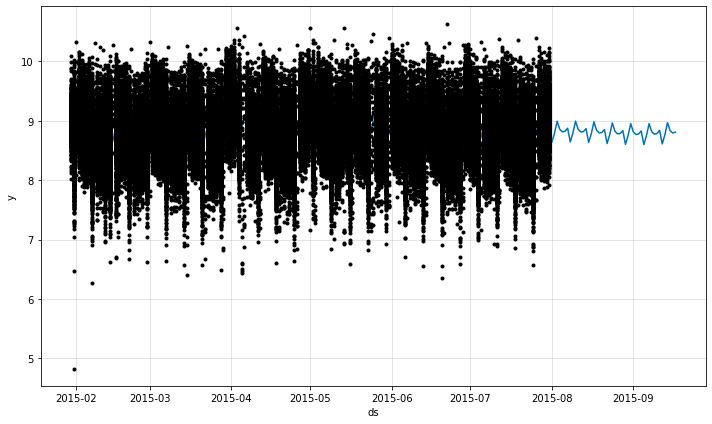

In [308]:
forecasts_plot = mn.plot(forecast)


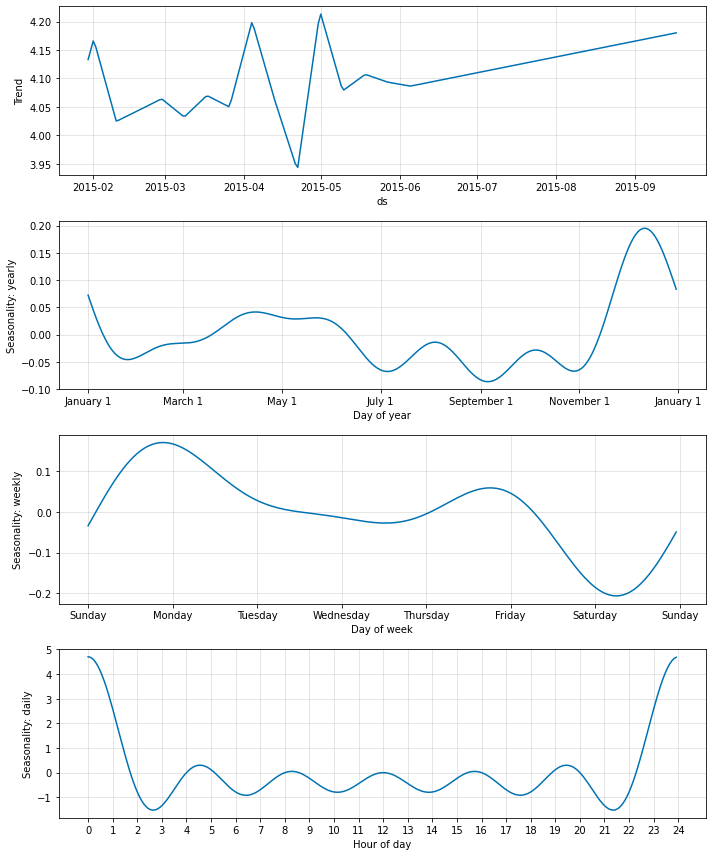

In [309]:
fig_comp = mn.plot_components(forecast)

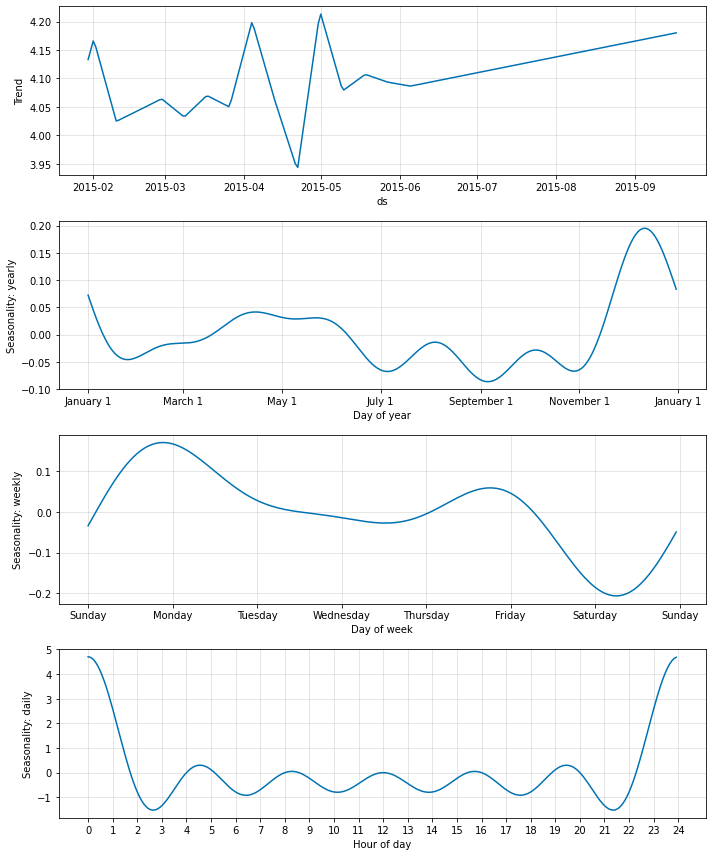

In [310]:
fig2 = mn.plot_components(forecast)

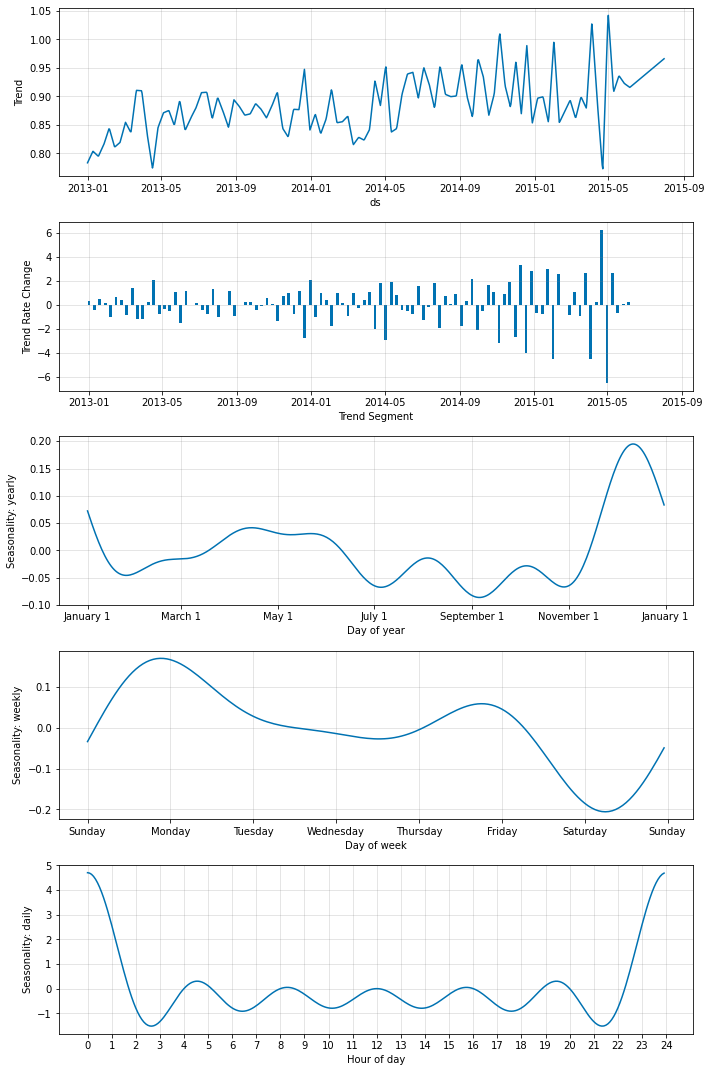

In [311]:
fig_param = mn.plot_parameters()
